In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [33]:
import requests
import json
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt

In [4]:
AZ_URL = "https://knowledge-base-api-dev.etsycloud.com/api/arizona/v1/datasets/query_classifier_prolist_search_purchases_6mo/rows/{:s}"

In [5]:
def format_taxonomy_to_second_level(taxo_path: str):
    if "." in taxo_path:
        return ".".join(taxo_path.split(".")[:2])
    else:
        return taxo_path + "."    

In [6]:
%%bigquery train_df
select
    ctx.docInfo.queryInfo.query, 
    ctx.docInfo.queryInfo.queryTaxoDemandFeatures.*,
from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_08_18`, unnest(contextualInfo) as ctx
where ctx.docInfo.queryInfo.query is not null
and array_length(ctx.docInfo.queryInfo.queryTaxoDemandFeatures.purchaseLevel2TaxonomyPaths) > 0
limit 500000

Downloading: 100%|█████████████████| 500000/500000 [00:10<00:00, 46897.34rows/s]


In [7]:
unique_queries = list(train_df["query"].unique())
len(unique_queries)

10309

In [8]:
unique_queries[:10]

['friends poster',
 'mailbox sign',
 'briefkastenschild',
 'louis vuitton box',
 'earring and tikka set',
 'wooden sign',
 'holzschild',
 'muscle suit',
 'silver bead',
 'channel orange']

Sanity check predicted probability sum to 1

In [9]:
for i in range(len(unique_queries)):
    if i % 1000 == 0:
        print(i)
    curr_query = unique_queries[i]
    response = requests.get(AZ_URL.format(curr_query))
    if response.ok:
        payload = response.json()
        if "value" in payload:
            az_data = json.loads(payload["value"])
            
            curr_sum = 0.
            for item in az_data:
                curr_sum += item["predicted_probability"]
                
            if np.abs(curr_sum - 1.) >= 0.011:
                # seeing max sum 0.9899
                print(curr_query)
                print(curr_sum)

0
1000
2000
3000
4000
5000
6000
sewing
0.9882387125053356
7000
8000
9000
10000


In [17]:
query_taxo_data = {}

for i in range(len(unique_queries)):
    if i % 1000 == 0:
        print(i)
    curr_query = unique_queries[i]
    response = requests.get(AZ_URL.format(curr_query))
    if response.ok:
        payload = response.json()
        if "value" in payload:
            az_data = json.loads(payload["value"])
            
            ## process train features
            feature_df = train_df[train_df["query"] == curr_query][["purchaseLevel2TaxonomyPaths", "purchaseLevel2TaxonomyCounts"]]
            feature_df.reset_index(inplace=True)
            feature_path = list(feature_df["purchaseLevel2TaxonomyPaths"][0])
            feature_counts = list(feature_df["purchaseLevel2TaxonomyCounts"][0])
            s_counts = np.float32(np.sum(feature_counts))
            feature_score = [x / s_counts for x in feature_counts] 
            
            ## process AZ dataset
            agg_az_path_score = {}
            for item in az_data:
                az_path_formatted = format_taxonomy_to_second_level(item["taxonomy"])
                if az_path_formatted in agg_az_path_score:
                    agg_az_path_score[az_path_formatted] += item["predicted_probability"]
                else:
                    agg_az_path_score[az_path_formatted] = item["predicted_probability"]
             
            agg_az_path_score_list = [(v, k) for k, v in agg_az_path_score.items()]
            agg_az_path_score_list = sorted(agg_az_path_score_list, reverse=True)
            az_path = [x[1] for x in agg_az_path_score_list]
            az_score = [x[0] for x in agg_az_path_score_list]
            
            query_taxo_data[curr_query] = {
                "feature_path": feature_path,
                "feature_score": feature_score,
                "az_path": az_path,
                "az_score": az_score
            }
            
#             if i % 500 == 0:
#                 print(query_taxo_data[curr_query])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [19]:
len(query_taxo_data)

5506

5506 / 10309 = 53% hit rate

In [21]:
more_feature_taxo = 0
more_az_taxo = 0

for query_str, values in query_taxo_data.items():
    if len(values["feature_path"]) >= len(values["az_path"]):
        more_feature_taxo += 1
    else:
        more_az_taxo += 1
        
print(more_feature_taxo)
print(more_az_taxo)

462
5044


In [36]:
iou_seq = []
corr_seq = []

for query_str, values in query_taxo_data.items():
    curr_feature_path = values["feature_path"]
    curr_az_path = values["az_path"]
    curr_feature_score = values["feature_score"]
    curr_az_score = values["az_score"]

    f_path_set = set(curr_feature_path)
    az_path_set = set(curr_az_path)

    path_intersection = f_path_set.intersection(az_path_set)
    path_union = f_path_set.union(az_path_set)
    iou = len(path_intersection) / len(path_union)

    f_score_ranked = []
    az_score_ranked = []
    for p in path_intersection:
        if p in f_path_set:
            f_score_ranked.append(curr_feature_score[curr_feature_path.index(p)])
        else:
            f_score_ranked.append(0.)

        if p in az_path_set:
            az_score_ranked.append(curr_az_score[curr_az_path.index(p)])
        else:
            az_score_ranked.append(0.)

    curr_corr = np.corrcoef(f_score_ranked, az_score_ranked)[0, 1]
    
    iou_seq.append(iou)
    corr_seq.append(curr_corr)

/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/yzhang/development/yzhang-adhoc-analysis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/yz

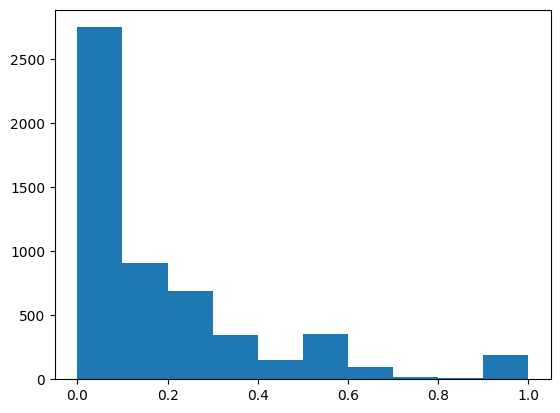

In [37]:
plt.hist(iou_seq)
plt.show()

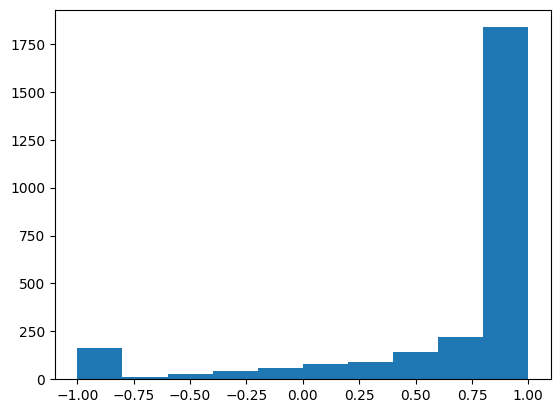

In [38]:
plt.hist(corr_seq)
plt.show()